# Observing Window

In [126]:
# Import modules
import datetime
import spiceypy as sp
import numpy as np
from astropy.time import Time
from astropy import units as u
from matplotlib import pyplot as plt
from matplotlib import dates as plt_dates

# Load the SPICE kernels via a meta file
sp.furnsh('kernel_meta.txt')

T1_UTC = Time("2000-01-01T00:00:00", scale="utc")
T2_UTC = Time("2000-06-01T00:00:00", scale="utc")

print(f"Start time in UTC: {T1_UTC.utc.strftime('%Y-%m-%dT%H:%M:%S'):s}")
print(f" End  time in UTC: {T2_UTC.utc.strftime('%Y-%m-%dT%H:%M:%S'):s}\n")

times_utc = Time(np.arange(T1_UTC.utc, T2_UTC.utc, 1*u.h)).utc
times_et = np.array([sp.utc2et(_t) for _t in times_utc.to_value("iso")])

Start time in UTC: 2000-01-01T00:00:00
 End  time in UTC: 2000-06-01T00:00:00



Compute now the phase angle between Venus and Sun as seen from Earth.

For this computation we need the SPICE function ``phaseq``. I think the arguments are not well named for ``phaseq(et, target, illmn, obsrvr, abcorr)``. It should be understood as

```
    phaseq(et, center, obj1, obj2, abcorr)
```

The alphas we will calculate:
1. First,
   * center: Earth (399)
   * objs: Sun (10) & Venus (299).
2. Second,
   * center: Earth (399)
   * objs: Sun (10) & Moon (301).
3. Last,
   * center: Earth (399)
   * objs: Venus (299) & Moon (301).

We apply a correction that considers the movement of the planets and the light time (``"LT+S"``).

In [119]:
a_sev = np.array(
    [np.rad2deg(sp.phaseq(et=_t, target='Earth', illmn='Sun', obsrvr='Venus', abcorr='LT+S')) for _t in times_et]
)

a_sem = np.array(
    [np.rad2deg(sp.phaseq(et=_t, target='Earth', illmn='Sun', obsrvr='Moon', abcorr='LT+S')) for _t in times_et]
)

a_vem = np.array(
    [np.rad2deg(sp.phaseq(et=_t, target='Earth', illmn='Venus', obsrvr='Moon', abcorr='LT+S')) for _t in times_et]
)

Consider we want to filter out images where 
1. S-E-V > 30°
2. S-E-M > 30°
3. V-E-M < 10°

In [120]:
mask_photogenic = ((a_sev > 30) & (a_sem > 30) & (a_vem < 10))
print(f'Computed:   {len(times_utc)} hr (around {len(times_utc)/24:.1f} days)' )
print(f'Photogenic: {np.count_nonzero(mask_photogenic)} hr (around {np.count_nonzero(mask_photogenic)/24:.1f} days)')

Computed:   3648 hr (around 152.0 days)
Photogenic: 68 hr (around 2.8 days)


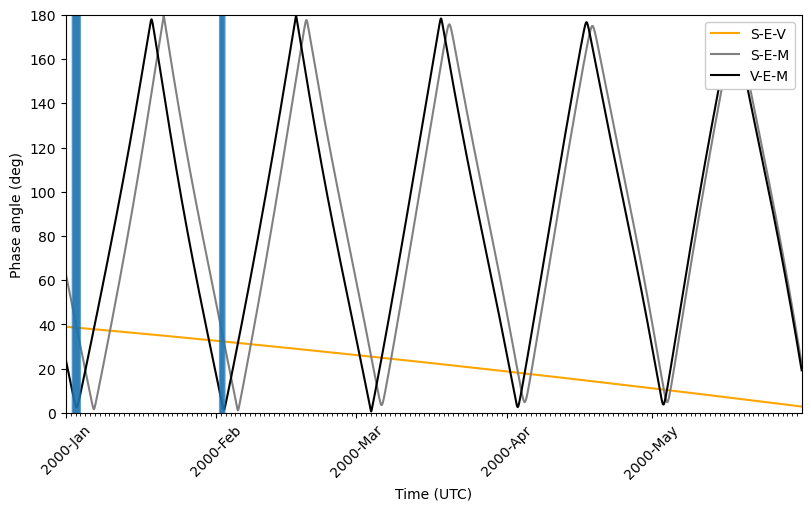

In [136]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

ax = axs

ax.plot(times_utc.plot_date, a_sev, color="orange", label='S-E-V')
ax.plot(times_utc.plot_date, a_sem, color="gray", label='S-E-M')
ax.plot(times_utc.plot_date, a_vem, color="k", label='V-E-M')
ax.xaxis.set_major_locator(plt_dates.MonthLocator())
ax.xaxis.set_minor_locator(plt_dates.DayLocator())
ax.xaxis.set_major_formatter(plt_dates.DateFormatter('%Y-%b'))

ax.set(
    xlabel='Time (UTC)',
    ylabel='Phase angle (deg)',
    xlim=(times_utc[0].plot_date, times_utc[-1].plot_date),
    ylim=(0, 180),
)

for photogenic_utc in times_utc[mask_photogenic]:
    ax.axvline(photogenic_utc.plot_date, color='tab:blue', alpha=0.2)

# Create the legend in the top right corner of the plot
ax.legend(fancybox=True, loc='upper right', framealpha=1)

# Rotate the date-times
plt.xticks(rotation=45)

plt.savefig("VENUS_SUN_MOON.png", dpi=300)